# Building Control Simultor Demo using Dummy Data from generator
This demo will run the building control simulator using a dummy data generator. Follow the steps below to see how the building control simulator looks in action. 

In [1]:
import imp
import os
import logging

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly
import statsmodels

from BuildingControlsSimulator.Simulator.Simulator import Simulator
from BuildingControlsSimulator.Simulator.Config import Config
from BuildingControlsSimulator.BuildingModels.IDFPreprocessor import IDFPreprocessor
from BuildingControlsSimulator.BuildingModels.EnergyPlusBuildingModel import EnergyPlusBuildingModel
from BuildingControlsSimulator.ControllerModels.Deadband import Deadband

from BuildingControlsSimulator.DataClients.LocalSource import LocalSource
from BuildingControlsSimulator.DataClients.LocalDestination import LocalDestination
from BuildingControlsSimulator.DataClients.DataSpec import DonateYourDataSpec
from BuildingControlsSimulator.DataClients.DataClient import DataClient
from BuildingControlsSimulator.DataClients.GCSDYDSource import GCSDYDSource
from BuildingControlsSimulator.OutputAnalysis.OutputAnalysis import OutputAnalysis
from BuildingControlsSimulator.StateEstimatorModels.LowPassFilter import LowPassFilter
from BuildingControlsSimulator.DataClients.DataDestination import DataDestination
from BuildingControlsSimulator.DataClients.DataStates import STATES

plotly.offline.init_notebook_mode(connected=True)
%load_ext autoreload
%autoreload 2

## Show EnergyPlus version

In [2]:
!energyplus --version

EnergyPlus, Version 9.4.0-998c4b761e


## Create a simulation configuration object
This object is used to describe the "framework" of the simulation. This will be used to generate dummy data and give configuration details for the simulation. 

In [3]:
sim_config = Config.make_sim_config(
    identifier="dummy_data",
    latitude=33.481136,
    longitude=-112.078232,
    start_utc="2018-01-05",
    end_utc="2018-01-10",
    min_sim_period="3D",
    sim_step_size_seconds=300,
    output_step_size_seconds=300,
)

## Generate Dummy Data
Using the sim_config, this method will generate fake data to be used in the demo simulation.

In [4]:
dummy_data = DataClient.generate_dummy_data(sim_config=sim_config, spec=DonateYourDataSpec())

## Save Dummy Data to File

In [5]:
file_extension = "parquet.gzip"
file_path = os.path.join(os.environ.get("LOCAL_CACHE_DIR"), f"input/local/{sim_config.iloc[0].identifier}.{file_extension}")
DataDestination.write_data_static(dummy_data, file_path, file_extension)

## Create the Data Client, Load Building Model, Initialize Simulator
This cell creates a number of important objects that are used in the simulation. 

The data client is used to help faciliate data translation from input -> simulator -> output.

The building model is an `.idf` model. The `IDFPreprocesor` can also override the specifications in the `.idf`. 

The last step is initilazing the simulator object.

In [6]:
%%time

dummy_data_client = DataClient(
            source=LocalSource(
                local_cache=os.environ.get("LOCAL_CACHE_DIR"),
                data_spec=DonateYourDataSpec(),
            ),
            destination=LocalDestination(
                local_cache=os.environ.get("LOCAL_CACHE_DIR"),
                data_spec=DonateYourDataSpec(),
            ),
        )

building_models = [
        EnergyPlusBuildingModel(
            step_size_seconds = 300,
            idf=IDFPreprocessor(idf_file="../test/idf/v9-4-0/slab_1story_2000sqft_gasfurnace_AC.idf",
                building_config={
                    "infiltration_ventilation": {
                        # Adjusts infiltration ventilation rates according to ASHRAE Standard 62.2
                        "ach50": 8,
                        "wsf": 0.43,  # weather and shielding factor in Appendix B for site location
                    },
                    "insulation_r_si": {
                        # Modifies any `Construction` object in the IDF file to have the specified R-value
                        "Interior Ceiling": 5.3,  # °C⋅m2/W
                        "Exterior Wall": 2.0,  # °C⋅m2/W
                        "Exterior Floor": 1.8,  # °C⋅m2/W
                    },
                    "windows": {
                        # Modifies all `Window` objects in the IDF file with the following parameters
                        "u_factor": "1.2",
                        "solar_heat_gain": 0.20,
                        "visible_transmittance": 0.60,
                    },
                    "hvac": {
                        # "heating_stages": 1,  # "heating_stages" does not appear to be currently implemented in `IDFPreprocessor`
                        # "heating_equipment": "gas_furnace",  # "heating_stages" does not appear to be currently implemented in `IDFPreprocessor`
                        "heating_sizing_factor": 2.0,  # Scales the size of all heating systems
                        # "cooling_stages": 1,  # "cooling_stages" does not appear to be currently implemented in `IDFPreprocessor`
                        # "cooling_equipment": "dx_ac",  # "cooling_equipment" does not appear to be currently implemented in `IDFPreprocessor`
                        "cooling_sizing_factor": 2.0,  # Scales the size of all heating systems
                    },
                    "thermal_mass": 1e7,
                },
           ),
        )
    ]

simulator = Simulator(
    data_client= dummy_data_client,
    sim_config=sim_config,
    building_models=building_models,
    state_estimator_models=[
        LowPassFilter(alpha_temperature=0.2, alpha_humidity=0.2)
    ],
    controller_models=[Deadband(options={'deadband': 1.0},  discretization_size_seconds=300),],
)

CPU times: user 3.47 s, sys: 126 ms, total: 3.6 s
Wall time: 3.62 s


## Run the Simulation

`simulator.simulate()` will use the Simulator object created above to run the full simulation according to the sim_config specified above.

In [7]:
%%time
# simulate
simulator.simulate(local=True, preprocess_check=False)

Co-simulation steps: 100%|██████████| 1645/1645 [00:14<00:00, 112.06it/s]


CPU times: user 9.8 s, sys: 1.35 s, total: 11.1 s
Wall time: 52.8 s


## View the Outputs
The final step is to use the OutputAnalysis object to create some preliminary plots based on the output data. 

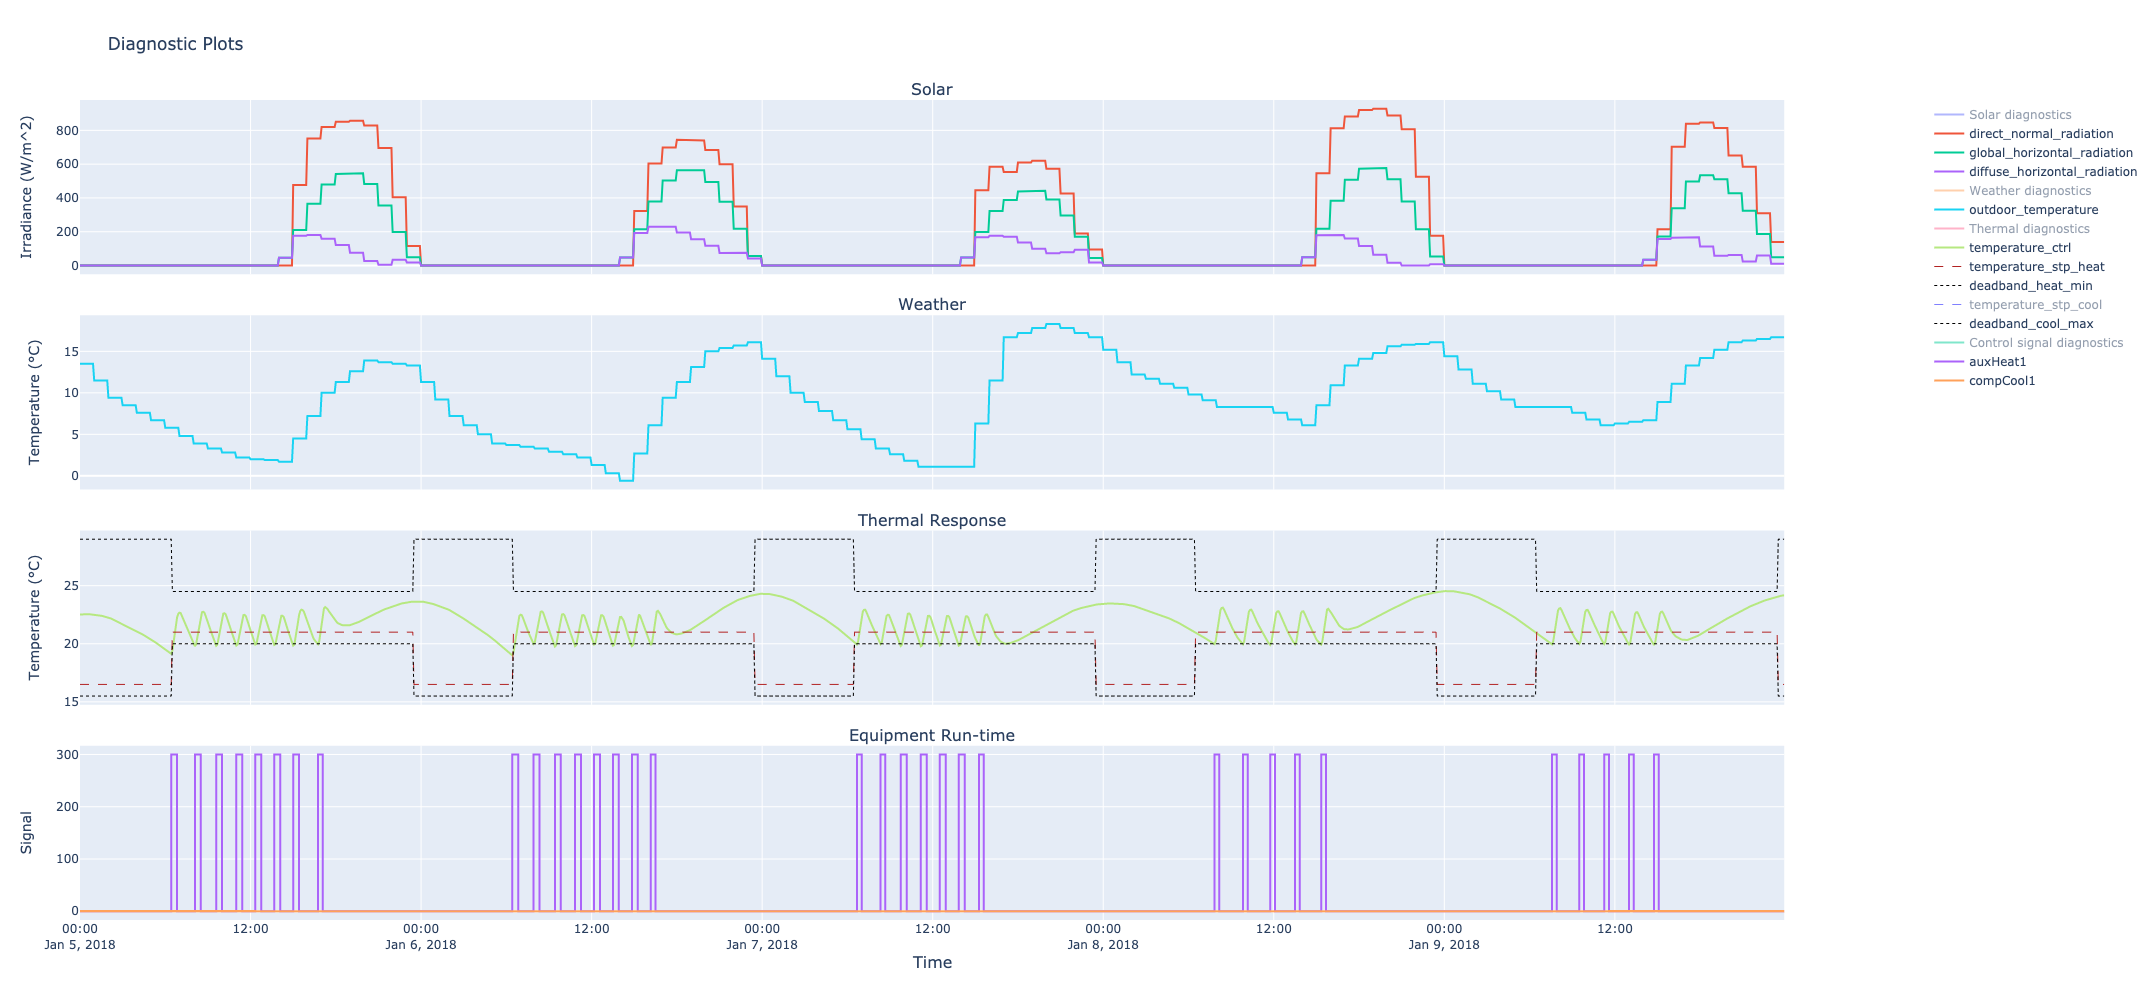

In [8]:
sim_analysis = OutputAnalysis(simulator.simulations, dummy_data_client.internal_spec)
sim_analysis.diagnostic_plot(show=True, actuals=False)